# Setup

In [1]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv('test.csv')

In [3]:
train.head(5)


,sku_id,country_name,retailer,breadcrumbs,breadcrumbs_t,name,name_t,pack_size,pack_size_t,description_short,description_t_short,resnet50_labels_005,resnet50_labels_06,price,label,label_id
0,22790,USA,amazon,"[""""Beauty & Personal Care"""",""""Tools & Accessor...","[""""Beauty & Personal Care"""",""""Tools & Accessor...","Q-tips Cotton Swabs, 170 ct","Q-tips Cotton Swabs, 170 ct",NaN,NaN,q-tips cotton swabs have a wide variety of use...,q-tips cotton swabs have a wide variety of use...,Band_Aid~can_opener~screwdriver,NaN,2.01000,OUT OF SCOPE,1
1,60540,USA,Chewy,"[""""Dog"""",""""Bowls & Feeders"""",""""Fountains & Fil...","[""""Dog"""",""""Bowls & Feeders"""",""""Fountains & Fil...","Petmate Fresh Flow Replacement Filters, 6 count","Petmate Fresh Flow Replacement Filters, 6 count",8.3 x 0.6 ...,8.3 x 0.6 ...,description the petmate deluxe fresh flow repl...,description the petmate deluxe fresh flow repl...,Band_Aid~web_site,NaN,7.00000,OUT OF SCOPE,1
2,96170,United Kingdom,Asda,"[""""Free From"""",""""Free From Chilled & Meat"""",""""...","[""""Free From"""",""""Free From Chilled & Meat"""",""""...",ASDA Free From Plain Soya Yogurt,ASDA Free From Plain Soya Yogurt,500g,500g,net content 500 grams ℮ lifestyle suitable for...,net content 500 grams ℮ lifestyle suitable for...,lotion~sunscreen,sunscreen,1.26185,Plain Yoghurt,7
3,116045,USA,jet.com,"[""""Pantry & Household"""",""""Household Supplies""""...","[""""Pantry & Household"""",""""Household Supplies""""...","Off! Deep Woods Dry Aerosol, 4 Oz","Off! Deep Woods Dry Aerosol, 4 Oz",12,12,description specs includes 25% deet formula. p...,description specs includes 25% deet formula. p...,can_opener~face_powder~oil_filter~tennis_ball,NaN,6.21000,OUT OF SCOPE,1
4,120858,USA,CVS,"[""""Vitamins"""",""""Herbals""""]","[""""Vitamins"""",""""Herbals""""]",Nature's Answer Damiana Leaf Vegetarian Capsul...,Nature's Answer Damiana Leaf Vegetarian Capsul...,90 CT,90 CT,nature's answer capsules feature the highest q...,nature's answer capsules feature the highest q...,face_powder~pill_bottle~sunscreen,pill_bottle,8.49000,OUT OF SCOPE,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3983 entries, 0 to 3982
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sku_id               3983 non-null   int64  
 1   country_name         3983 non-null   object 
 2   retailer             3983 non-null   object 
 3   breadcrumbs          3983 non-null   object 
 4   breadcrumbs_t        3983 non-null   object 
 5   name                 3983 non-null   object 
 6   name_t               3983 non-null   object 
 7   pack_size            689 non-null    object 
 8   pack_size_t          688 non-null    object 
 9   description_short    3004 non-null   object 
 10  description_t_short  3003 non-null   object 
 11  resnet50_labels_005  3892 non-null   object 
 12  resnet50_labels_06   1308 non-null   object 
 13  price                3820 non-null   float64
 14  label                3983 non-null   object 
 15  label_id             3983 non-null   i

In [5]:
#Keeping only translated columns
train.drop(["breadcrumbs","name","pack_size", "description_short"],axis=1,inplace=True)
test.drop(["breadcrumbs","name","pack_size", "description_short"],axis=1,inplace=True)

#### Checking for null values

In [6]:
print(train.isna().sum(axis=0))

sku_id                    0
country_name              0
retailer                  0
breadcrumbs_t             0
name_t                    0
pack_size_t            3295
description_t_short     980
resnet50_labels_005      91
resnet50_labels_06     2675
price                   163
label                     0
label_id                  0
dtype: int64


In [7]:
print(test.isna().sum(axis=0))

sku_id                   0
country_name             0
retailer                 0
breadcrumbs_t            0
name_t                   0
pack_size_t            791
description_t_short    245
resnet50_labels_005     30
resnet50_labels_06     683
price                   35
dtype: int64


Quite a few values show up as NaN. Let's fill the NaN values of the description_t collumn with a respective name_t value.

In [8]:
train['description_t_short'].fillna(train.name_t,inplace=True)
test['description_t_short'].fillna(test.name_t,inplace=True)




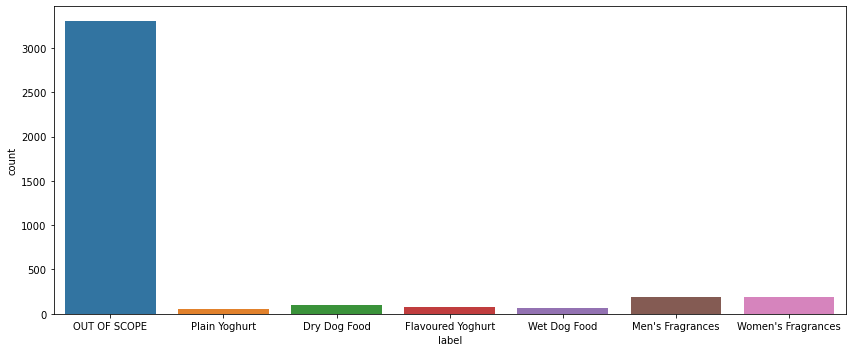

In [9]:
fig, ax = plt.subplots(figsize = (12,5))
sns.countplot(x=train["label"],ax=ax)
plt.tight_layout()

The distribution of labels is severely skewed which might make it difficult to classify.

## Defining functions

A function to remove emojis and other symbols from a string

In [10]:

import re
def remove_emoji(s):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  #flags ios
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r"",s)
    

A function to remove punctuation from a string

In [11]:

def remove_punctuation(x):
    x = str(x)
    temp = [c for c in x if c not in string.punctuation]
    return ''.join(temp)

A function to remove basic english words that don't provide any valuable meaning

In [12]:

def remove_stop_words(x):
    temp = x.split()
    temp2 =  [word for word in temp if word.lower() not in stopwords.words('english')]
    return " ".join(temp2)

A function to remove digits from a string

In [13]:
from string import digits
def remove_num(s):
    remove_digits = str.maketrans('', '', digits)
    res = s.translate(remove_digits)
    return res

A function to remove words with number of letters > n

In [14]:
def remove_over_n(x,n):
    new = []
    for item in range(len(x)-1):
        if len(x[item]) < n:
            new.append(x[item])
        
    return new    
            

A function to remove words with number of letters < n

In [15]:
def remove_under_n(x,n):
    new = []
    for item in range(len(x)-1):
        if len(x[item]) > n:
            new.append(x[item])
        
    return new    

In [16]:
train.groupby('label').mean()

,sku_id,price,label_id
label,,,
Dry Dog Food,9.545084e+07,36.323218,2.0
Flavoured Yoghurt,6.321227e+07,4.033883,6.0
Men's Fragrances,1.050615e+08,61.358527,3.0
OUT OF SCOPE,9.950144e+07,37.778727,1.0
Plain Yoghurt,8.172382e+07,4.455524,7.0
Wet Dog Food,8.101354e+07,15.493023,5.0
Women's Fragrances,1.064794e+08,59.213766,4.0


Above we can see an average price for each label. It seems like the price could be a good indicator to differentiate between products.

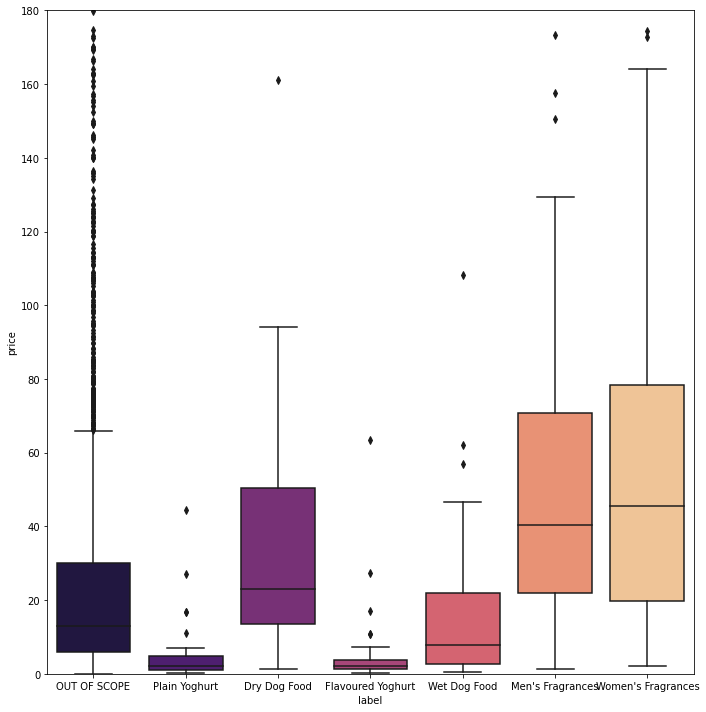

In [17]:
plt.figure(figsize=(10,10))
plt.ylim(0,180)
sns.boxplot(x="label", y='price', data=train, palette = 'magma')
plt.tight_layout()

We can see that similar products like Plain and Flavoured Yoghurts have similar price distributions. The same applies for fragrances as well as dog food. However the distribution of prices for products that are labeled "OUT OF SCOPE" covers a wide range so it would be tricky classifying products based on price alone.

This function will be used to round the price to the nearest item in myList list. This will place products in different groups based on price. The elements of myList were chosen based on the mean price of each label.

In [18]:
myList = [2,15,30,40,60]
def find_closest(a):
    return min(myList, key=lambda x:abs(x-a))


## Creating new features

#### Removing punctuation, capilatization, numbers, redundant words from descriptive columns and combining all relevant descriptors in 1 list. The list for each product is then stored in a "key_words_main" column.

In [19]:
train['new_price'] = train["price"].apply(find_closest).apply(lambda x: [str(x)])

In [20]:
train["description_list"] = train["description_t_short"].apply(remove_num).apply(remove_emoji).apply(remove_punctuation).apply(remove_stop_words).apply(lambda x: x.split(' '))
train['description_list'].apply(lambda x: remove_over_n(x,15)).apply(lambda x: remove_under_n(x,2))

0       [qtips, cotton, swabs, wide, variety, uses, in...
1       [description, petmate, deluxe, fresh, flow, re...
2       [net, content, grams, lifestyle, suitable, veg...
3       [description, specs, includes, deet, formula, ...
4       [natures, answer, capsules, feature, highest, ...
                              ...                        
3978                                        [hand, towel]
3979    [goyangijelri, taste, jelly, tuna, shrimp, piece]
3980                                           [fragrant]
3981                                [brushes, disposable]
3982    [burberry, british, rhythm, floral, eau, toile...
Name: description_list, Length: 3983, dtype: object

In [21]:
train["crumbList"] = train["breadcrumbs_t"].replace(',',' ').apply(remove_punctuation).apply(remove_stop_words).apply(lambda x: x.lower()).apply(lambda x: x.split(' '))

In [22]:
train["country_list"] = train['country_name'].apply(lambda x: [x.lower()])

In [23]:
train["retailer_list"] = train['retailer'].apply(lambda x: [x.lower()])

In [24]:
train['name_to-list'] = train["name_t"].apply(remove_punctuation).apply(remove_stop_words).apply(lambda x: x.lower().split(' '))

### Combining all lists into one

In [25]:
train['key_words_main'] = train["description_list"] + train["crumbList"] +train["country_list"]+train["retailer_list"]+train["new_price"]

In [26]:
#train["final"]=train["key_words_main"].apply(lambda x: remove_over_n(x,15)).apply(lambda x: remove_under_n(x,2))

### Create same features for the test data frame

In [27]:
test['new_price'] = test["price"].apply(find_closest).apply(lambda x: [str(x)])

In [28]:
test["description_list"] = test["description_t_short"].apply(remove_num).apply(remove_emoji).apply(remove_punctuation).apply(remove_stop_words).apply(lambda x: x.split(' '))
test['description_list'].apply(lambda x: remove_over_n(x,15)).apply(lambda x: remove_under_n(x,2))

0      [fast, free, shipping, unique, aneeq, branded,...
1      [description, specs, lint, roller, made, scotc...
2      [information, description, dried, yeast, essen...
3      [dispose, used, blades, safely, cutting, perfo...
4      [Guide, Gear, Mens, Nylon, Snake, Boots, Water...
                             ...                        
990                 [mouthpiece, guard, iagmulgi, teeth]
991    [heater, cartridge, waxy, provide, team, neces...
992    [Hangsun, Idropulsore, dental, HOC, Profession...
993    [znaiu, ostanovishsia, way, great, pobedam, sc...
994    [Reusable, Menstrual, Cup, Sizes, Pack, Pink, ...
Name: description_list, Length: 995, dtype: object

In [29]:
test["crumbList"] = test["breadcrumbs_t"].replace(',',' ').apply(remove_punctuation).apply(remove_stop_words).apply(lambda x: x.lower()).apply(lambda x: x.split(' '))

In [30]:
test["country_list"] = test['country_name'].apply(lambda x: [x.lower()])

In [31]:
test["retailer_list"] = test['retailer'].apply(lambda x: [x.lower()])

In [32]:
test['name_to-list'] = test["name_t"].apply(remove_punctuation).apply(remove_stop_words).apply(lambda x: x.lower().split(' '))

In [33]:
test['key_words_main'] = test["description_list"] + test["crumbList"] +test["country_list"]+test["retailer_list"]+test["new_price"]

# Vectorization

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

Here the label_id is our target variable and the key_words_main attribute is the predictor.

In [35]:
y_train = train['label_id']
X_train = train["key_words_main"]

X_test = test['key_words_main']


In [36]:
cv = CountVectorizer(analyzer=lambda x: x)

In [37]:
X_train = cv.fit_transform(X_train)
X_test = cv.transform(X_test)

In [38]:
#from sklearn.model_selection import train_test_split

In [39]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a model

In [40]:
from sklearn.naive_bayes import MultinomialNB

In [41]:
nb = MultinomialNB()

In [42]:
nb.fit(X_train,y_train)

MultinomialNB()

# Predictions and Evaluations

In [43]:
predictions = nb.predict(X_test)

In [44]:
#from sklearn.metrics import confusion_matrix, classification_report

In [45]:
#print(classification_report(y_test,predictions))

In [46]:
test_pred_template = pd.read_csv("test_pred_template.csv")

In [47]:
test_pred_template

,sku_id,label_id
0,193691,NaN
1,194042,NaN
2,225668,NaN
3,351205,NaN
4,374160,NaN
...,...,...
990,271665484,NaN
991,275348804,NaN
992,275400954,NaN
993,276209365,NaN


In [48]:
predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 6, 1, 1,

In [49]:
test["label_id"] = predictions
test_pred = test[["sku_id", 'label_id']]
test_pred.to_csv("test-pred.csv",index=False)

# Conclusion

As we can see the model has classified most of the products into group 1. This is most likely due to an imbalanced training data. 

Some ways to improve the model:
* Collecting more data
* Trying a more sophisticated algorithms than Naive Bayes.
* Resampling data-set to add more copies of instances from the under-represented classes
* Explore the data in more depth to create better features.
    

<AxesSubplot:xlabel='label_id', ylabel='count'>

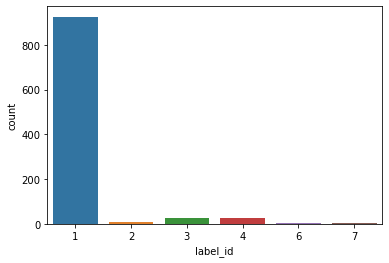

In [50]:
sns.countplot(data=test, x='label_id')